In [22]:
import pandas as pd
# Set max columns to display
pd.set_option('display.max_columns', None)

import numpy as np
from sklearn import preprocessing as pre
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import plotly.express as px

In [23]:

df_All_1 = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\1 Preprocess\Merge Data\contData_all_Avg_1o2.csv')
df_All_2 = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\1 Preprocess\Merge Data\contData_all_Avg_2o2.csv')
# Concatenate (union) the dataframes
df_All = pd.concat([df_All_1, df_All_2], ignore_index=True)

print(df_All.head())

   425_pct_Al  M_Value  C4_pct_Eth  C4_pct_H2O  C4_pct_Hex  \
0    6.307630  3.50893    2.508420    21.96340    0.659256   
1    6.308335  3.50863    2.511135    21.96865    0.659930   
2    6.309390  3.50818    2.515210    21.97655    0.660942   
3    6.310090  3.50788    2.517925    21.98185    0.661616   
4    6.310790  3.50758    2.520640    21.98715    0.662291   

   HydWtr_pct_Ammonia  HydWtr_Na2O   DI55152   FC55003       FC55552  \
0            0.908765     2.712180  0.925255  4919.290  41564.100000   
1            0.907643     2.805415  0.924281  5039.445  41558.250000   
2            0.905959     2.945270  0.923773  5268.620  41524.066667   
3            0.904837     3.038505  0.924103  5349.320  41500.275000   
4            0.903715     3.131740  0.924258  5563.165  41466.625000   

       FC55569  FFC55553  FFC55555    LC55555   PI55004   TC55552     TC55555  \
0  6918.110000  0.996975  0.751501  59.968800  1.306310  177.1880  180.125000   
1  6919.960000  0.998847  0.7505

In [24]:

TagDesc = pd.read_csv(r"C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\CSV\Not for Processing\TagDesc.csv")
# df_All = pd.read_csv(r"C:\Users\saust\OneDrive - Sasol\1 Project rC4\Jupyter Notebooks\Report 10-19-23\df_AlConCD554.csv")
#df_All = pd.read_csv(r"C:\Users\saust\OneDrive\Desktop\CodeSpace DLs\102423\Project rC4\5 Engineered Features\3 - EF - Feature Selection\df_CDFI.csv")


# FScore = pd.read_csv(r"C:\Users\saust\OneDrive\Desktop\CodeSpace DLs\102423\Project rC4\5 Engineered Features\3 - EF - Feature Selection\FScore_on_Butanol_310.csv")

# df_All = pd.read_csv('/workspaces/codespaces-jupyter/ProjectrC4/df_AlConCD554.csv')

In [25]:
# # List of columns to exclude to run XGboost feature selection
# exclude_columns = [
       
#        # Sample data of the same time introcuces Data leakage
#        'Octanol', 'Hexanol', 'Ethanol', 'Decanol',

#        # Highly correlated to TC's
#        # "Normally the Exctraction temperature is run within a few degrees of the hydrolysis temperature."(Alumina Unit Effect p10) 
#        'TI52014', 'TI55013', 'TI55014', 'TI55015', 'TI55016', 'TI55017', 'TI55023', 'TI40050',

#        # , 'TI55021'
       
#        # Niro Functions
#        'TC52015', 'FC52018', 'II52554', 'VI52558B',
       
#        # .9 to .8 Correlations
#        'FC55555',  # First Drop - Highest correlated variable    #Almost 1 with FC55552 - as determined by Ratio controller    
#        'PI55560',   # Exlude middle pressure - Include -> PI5500: btm pressure 
#        'FYC55553',  # Calculates by other varibales (inherently correlated) - Include -> FC55552 - leading influecner 
#        'FC55152', 'FC55102', # Both are deritives of FC55552
#        'AYC55580',  # Is calculated - DI55580 measures the process directly
       
#        # .7 Correlations
#        # FC55552 --> FC42428 = 0.70526 / not comfortable droping either at this time

#        # .6 Correlations
#        'TC55566',  # Slurry coolers are a Downstream requirement - TC55552 occurs upstream (DC-551 ALKOX  FD PREHEAT)

#        # .5 Correlations
#        'FC55009' # Receives its SP from TC55553

#                    ]

# # Create a new DataFrame without the excluded columnsd
# df_All = df_All.drop(columns=exclude_columns)

# Check Basic Information:

In [26]:


df_All.info() #to check the data types, non-null counts, and memory usage.
df_All.head() #to examine the first few rows of the dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54701 entries, 0 to 54700
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   425_pct_Al          54701 non-null  float64
 1   M_Value             54701 non-null  float64
 2   C4_pct_Eth          54701 non-null  float64
 3   C4_pct_H2O          54701 non-null  float64
 4   C4_pct_Hex          54701 non-null  float64
 5   HydWtr_pct_Ammonia  54701 non-null  float64
 6   HydWtr_Na2O         54701 non-null  float64
 7   DI55152             54701 non-null  float64
 8   FC55003             54701 non-null  float64
 9   FC55552             54701 non-null  float64
 10  FC55569             54701 non-null  float64
 11  FFC55553            54701 non-null  float64
 12  FFC55555            54701 non-null  float64
 13  LC55555             54701 non-null  float64
 14  PI55004             54701 non-null  float64
 15  TC55552             54701 non-null  float64
 16  TC55

,425_pct_Al,M_Value,C4_pct_Eth,C4_pct_H2O,C4_pct_Hex,HydWtr_pct_Ammonia,HydWtr_Na2O,DI55152,FC55003,FC55552,FC55569,FFC55553,FFC55555,LC55555,PI55004,TC55552,TC55555,TI55021,Butanol
0,6.307630,3.50893,2.508420,21.96340,0.659256,0.908765,2.712180,0.925255,4919.290,41564.100000,6918.110000,0.996975,0.751501,59.968800,1.306310,177.1880,180.125000,212.861000,54.858300
1,6.308335,3.50863,2.511135,21.96865,0.659930,0.907643,2.805415,0.924281,5039.445,41558.250000,6919.960000,0.998847,0.750588,59.932300,1.181220,177.2505,180.053000,212.699000,51.190050
2,6.309390,3.50818,2.515210,21.97655,0.660942,0.905959,2.945270,0.923773,5268.620,41524.066667,6916.486667,0.998648,0.750505,60.002433,1.216603,177.4170,180.001667,212.822333,48.744567
3,6.310090,3.50788,2.517925,21.98185,0.661616,0.904837,3.038505,0.924103,5349.320,41500.275000,6918.470000,1.000349,0.750325,60.015925,1.206718,177.4590,180.010750,212.799750,46.604750
4,6.310790,3.50758,2.520640,21.98715,0.662291,0.903715,3.131740,0.924258,5563.165,41466.625000,6915.790000,1.000862,0.750021,60.020500,1.163892,177.5490,179.939500,212.853000,44.587220


# Summary Statistics:

In [27]:


df_All.describe() #to get summary statistics for numeric columns.


,425_pct_Al,M_Value,C4_pct_Eth,C4_pct_H2O,C4_pct_Hex,HydWtr_pct_Ammonia,HydWtr_Na2O,DI55152,FC55003,FC55552,FC55569,FFC55553,FFC55555,LC55555,PI55004,TC55552,TC55555,TI55021,Butanol
count,54701.000000,54701.000000,54701.000000,54701.000000,54701.000000,54701.000000,54701.000000,54701.000000,54701.000000,54701.000000,54701.000000,54701.000000,54701.000000,54701.000000,54701.000000,54701.000000,54701.000000,54701.000000,54701.000000
mean,6.112584,3.604726,1.274754,20.756146,0.461299,0.969410,0.795330,0.944165,5946.323971,36128.859598,6598.163591,0.993519,0.774488,58.558857,2.277310,168.496587,180.976139,223.245544,9.491176
std,0.316017,0.173736,0.677477,2.859486,0.240116,0.144668,0.738724,0.042737,794.065219,4270.390546,372.743929,0.040033,0.023074,10.526737,1.203949,14.922549,1.444870,8.910920,9.378743
min,0.252306,1.461875,0.086948,7.932310,0.000327,0.390025,-0.248116,0.815428,2991.532500,18800.350000,5190.967500,0.814484,0.697983,39.179775,0.031410,120.497500,176.303250,207.956750,0.424417
25%,5.987750,3.506780,0.675285,18.331550,0.342098,0.877716,0.409063,0.915431,5446.200000,34993.125000,6363.310000,0.970038,0.759833,49.916475,1.319045,156.057250,179.973500,217.915500,3.633750
50%,6.130470,3.595655,1.291115,20.731850,0.436248,0.942521,0.639486,0.939170,5961.932500,37885.750000,6580.852500,0.991442,0.779014,60.084475,2.031255,171.831000,180.082000,220.879250,5.765416
75%,6.270075,3.696090,1.719630,22.989150,0.533314,1.036325,0.989685,0.965307,6492.420000,38978.150000,6809.940000,1.012430,0.789958,67.886450,3.064095,180.383500,181.987250,224.748000,11.246987
max,8.020685,5.827565,8.711360,33.731050,3.163640,1.600715,13.991350,1.064850,8892.395000,42079.525000,8047.065000,1.159912,0.854999,79.265400,6.313537,212.425000,186.233000,256.574750,56.575000


# Check for Missing Values:

In [28]:


df_All.isnull().sum() #to check the number of missing values in each column.


425_pct_Al            0
M_Value               0
C4_pct_Eth            0
C4_pct_H2O            0
C4_pct_Hex            0
HydWtr_pct_Ammonia    0
HydWtr_Na2O           0
DI55152               0
FC55003               0
FC55552               0
FC55569               0
FFC55553              0
FFC55555              0
LC55555               0
PI55004               0
TC55552               0
TC55555               0
TI55021               0
Butanol               0
dtype: int64

# Correlation Analysis:

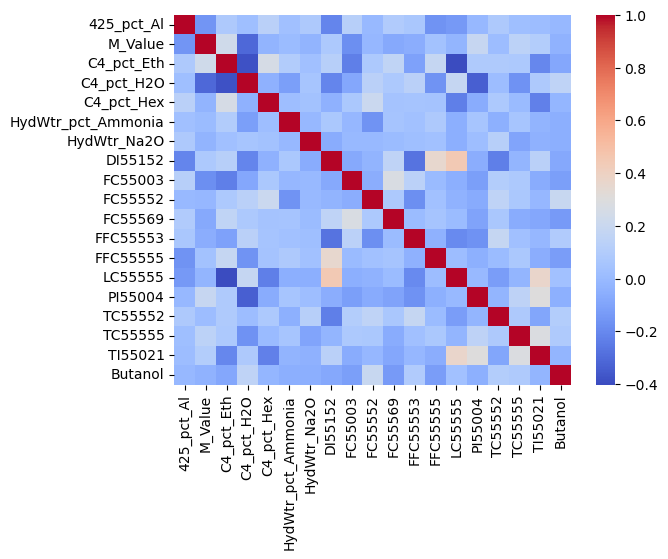

In [29]:
correlation_matrix = df_All.corr(numeric_only = True)

sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.show()
# Calculate and visualize correlations between numeric variables using a correlation matrix or heatmap.
# Identify strong positive/negative correlations.

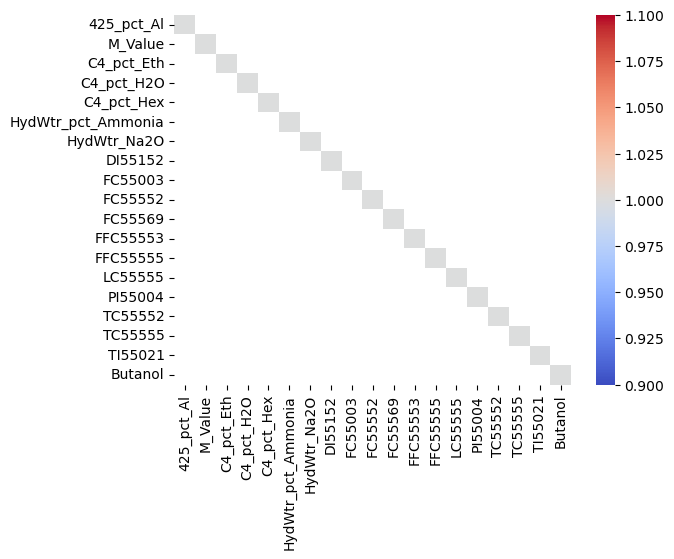

In [30]:
strong_corr = correlation_matrix[abs(correlation_matrix) > 0.5]

sns.heatmap(strong_corr, annot=False, cmap='coolwarm', fmt=".2f")
plt.show()

In [31]:
threshold = 0.5
correlation_matrix = df_All.corr(numeric_only=True)
correlation_matrix = correlation_matrix[abs(correlation_matrix) > threshold].fillna(0)



fig = px.imshow(correlation_matrix, 
                color_continuous_scale='Viridis',
                labels=dict(x="Features", y="Features", color="Correlation"),
                title="Correlation Matrix")

fig.update_xaxes(title_text='Features', side='bottom')
fig.update_layout(width=800, height=800)

fig.show()



In [32]:
upper_triangle = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)


In [33]:
# Get indices of upper triangle where correlations are above threshold
indices = np.where((np.abs(correlation_matrix) > threshold) & (upper_triangle))

# Convert these indices to lists
rows, cols = indices[0].tolist(), indices[1].tolist()

# Construct pairs and fetch corresponding values 'DESCRIPTION'


data = []
correlation_id = 1  # Start the unique identifier for each correlation pair

for row, col in zip(rows, cols):
    # Ensure v1 is always lexicographically smaller than v2
    v1, v2 = sorted([correlation_matrix.columns[row], correlation_matrix.columns[col]])
    
    # Skip if this pair has already been processed
    if any(x[1] == v1 and x[2] == v2 for x in data):
        continue

    correlation_value = correlation_matrix.loc[v1, v2]
    
    # Fetch other required values for v1
    # importance1 = FScore[FScore['Feature'] == v1]['Importance'].values[0] if not FScore[FScore['Feature'] == v1].empty else "N/A"
    DESCRIPTION1 = TagDesc[TagDesc['ID'] == v1]['DESCRIPTION'].values[0] if not TagDesc[TagDesc['ID'] == v1].empty else "####### UPDATE DESCRIPTION"
    
    # Fetch other required values for v2
    # importance2 = FScore[FScore['Feature'] == v2]['Importance'].values[0] if not FScore[FScore['Feature'] == v2].empty else "N/A"
    DESCRIPTION2 = TagDesc[TagDesc['ID'] == v2]['DESCRIPTION'].values[0] if not TagDesc[TagDesc['ID'] == v2].empty else "####### UPDATE DESCRIPTION"
    
    # Append data for v1 and then v2
    data.append(['c' + str(correlation_id) + 'v1', v1, correlation_value, DESCRIPTION1])#, importance1
    data.append(['c' + str(correlation_id) + 'v2', v2, correlation_value, DESCRIPTION2])#, importance2
    
    correlation_id += 1  # Increment the identifier for the next unique correlation pair

final_df = pd.DataFrame(data, columns=['Pair_ID', 'Variable', 'Correlation', 'DESCRIPTION'])#, 'Importance',

sorted_df = final_df.sort_values(by='Pair_ID', ascending=False)
print(sorted_df)


Empty DataFrame
Columns: [Pair_ID, Variable, Correlation, DESCRIPTION]
Index: []


In [34]:
sorted_df = final_df.sort_values(by='Variable', ascending=False)
print(sorted_df)


Empty DataFrame
Columns: [Pair_ID, Variable, Correlation, DESCRIPTION]
Index: []


In [35]:
# # Group by the first 3 characters of Pair_ID (i.e., cX) and sort within the groups by Importance
# final_df['Group'] = final_df['Pair_ID'].str[:3]
# sorted_df = final_df.groupby('Group').apply(lambda x: x.sort_values('Importance', ascending=False)).reset_index(drop=True)

# # Drop the temporary 'Group' column
# sorted_df.drop('Group', axis=1, inplace=True)

# print(sorted_df)


In [36]:
# sorted_df = final_df.sort_values(by='Importance', ascending=False)
# print(sorted_df)

In [37]:
# If you want to save df_CDFI to a .csv file:
sorted_df.to_csv('sorted_df.csv', index=False)

### No CSV Output

Next page starts will all data inputs and uses only those below

LIMS data lables need to be refomatted to input style or they will be left out

In [38]:
df_All.columns
# Data Visualization:

# Create various plots (histograms, bar charts, scatter plots, etc.) to visualize the distribution of data and relationships between variables.
# Use libraries like Matplotlib or Seaborn for data visualization.

Index(['425_pct_Al', 'M_Value', 'C4_pct_Eth', 'C4_pct_H2O', 'C4_pct_Hex',
       'HydWtr_pct_Ammonia', 'HydWtr_Na2O', 'DI55152', 'FC55003', 'FC55552',
       'FC55569', 'FFC55553', 'FFC55555', 'LC55555', 'PI55004', 'TC55552',
       'TC55555', 'TI55021', 'Butanol'],
      dtype='object')

In [39]:
num_columns = df_All.shape[1]
print("Number of features:", num_columns)

Number of features: 19
